#Analysis of CPU Performance - Balaji

Problem Statement: Predict teh PRP (Published Relative Performance) based on the otehr independent features

In [30]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import os

In [31]:
import numpy as np
import pandas as pd

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [34]:
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Setup helper functions

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map(df):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )


def describe_more(df):
    var = [];
    l = [];
    t = []
    for x in df:
        var.append(x)
        l.append(len(pd.value_counts(df[x])))
        t.append(df[x].dtypes)
    levels = pd.DataFrame({'Variable': var, 'Levels': l, 'Datatype': t})
    levels.sort_values(by='Levels', inplace=True)
    return levels


def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)


def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=X.columns
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[: 10].plot(kind='barh')
    print(model.score(X, y))

In [35]:
os.curdir #gives us the current directory
os.listdir() #Lists all the files in teh current directory
names = ['VENDOR','MODEL_NAME','MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP'] #Since our data has no lables we are creating a df with lables and will be later added to the Data
data = pd.read_csv('/Users/Balaji/PycharmProjects/Aon Project/data/machine.data', names= names)
data = pd.DataFrame(data)

In [36]:
pd.set_option('display.expand_frame_repr', False) # to display max cols & rows

#Exploratory Data Analysis

In [37]:
data.head() #shows the first five rows

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [38]:
data.tail() #shows last five rows

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47
208,wang,vs-90,480,1000,4000,0,0,0,45,25


In [39]:
data.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [40]:
data.info() #gives you information on the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
VENDOR        209 non-null object
MODEL_NAME    209 non-null object
MYCT          209 non-null int64
MMIN          209 non-null int64
MMAX          209 non-null int64
CACH          209 non-null int64
CHMIN         209 non-null int64
CHMAX         209 non-null int64
PRP           209 non-null int64
ERP           209 non-null int64
dtypes: int64(8), object(2)
memory usage: 16.4+ KB


In [41]:
#Copying ERP colum into a seperate dataframe
data_ERP =  data[data.columns[-1]]
data_ERP.head()
#Dropping ERP column
data=data.drop('ERP',axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
VENDOR        209 non-null object
MODEL_NAME    209 non-null object
MYCT          209 non-null int64
MMIN          209 non-null int64
MMAX          209 non-null int64
CACH          209 non-null int64
CHMIN         209 non-null int64
CHMAX         209 non-null int64
PRP           209 non-null int64
dtypes: int64(7), object(2)
memory usage: 14.8+ KB


In [73]:
describe_more(data)

,Variable,Levels,Datatype
6,CHMIN,15,int64
5,CACH,22,int64
4,MMAX,23,int64
3,MMIN,25,int64
0,VENDOR,30,object
7,CHMAX,31,int64
2,MYCT,60,int64
8,PRP,116,int64
1,MODEL_NAME,209,object


In [42]:
data.corr() #Correlation matrix to see the tentative dependencies between columns

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
MYCT,1.000000,-0.335642,-0.378561,-0.321000,-0.301090,-0.250502,-0.307099
MMIN,-0.335642,1.000000,0.758157,0.534729,0.517189,0.266907,0.794931
MMAX,-0.378561,0.758157,1.000000,0.537990,0.560513,0.527246,0.863004
CACH,-0.321000,0.534729,0.537990,1.000000,0.582245,0.487846,0.662641
CHMIN,-0.301090,0.517189,0.560513,0.582245,1.000000,0.548281,0.608903
CHMAX,-0.250502,0.266907,0.527246,0.487846,0.548281,1.000000,0.605209
PRP,-0.307099,0.794931,0.863004,0.662641,0.608903,0.605209,1.000000


In [43]:
data['VENDOR'].value_counts().sort_values(ascending=False)
data.groupby('VENDOR')['MODEL_NAME'].nunique().sort_values(ascending=False)
(data.groupby('VENDOR')['PRP'].mean()).sort_values(ascending=False)

VENDOR
amdahl          416.333333
sperry          254.923077
adviser         198.000000
gould           182.333333
nas             176.894737
cdc             130.111111
siemens         121.833333
basf            115.000000
ibm              85.093750
ipl              69.000000
ncr              63.307692
honeywell        60.461538
wang             56.000000
dg               54.142857
prime            53.800000
sratus           52.000000
burroughs        49.750000
harris           49.714286
dec              47.333333
cambex           42.800000
c.r.d            42.666667
perkin-elmer     41.666667
magnuson         39.666667
apollo           39.000000
hp               36.428571
four-phase       36.000000
nixdorf          32.000000
microdata        30.000000
bti              22.500000
formation        16.800000
Name: PRP, dtype: float64

Checking for Skewness.

What is Skewness?

Skewness. It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution. It differentiates extreme values in one versus the other tail.

Why it is important?
Reason: 

Skewed data leads to Bias.

Reference link: https://whatis.techtarget.com/definition/skewness

In [46]:
data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']].skew()

MYCT     2.544153
MMIN     3.515933
MMAX     2.140663
CACH     2.824777
CHMIN    4.027333
CHMAX    3.595905
PRP      3.892814
dtype: float64

In [107]:
data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']].kurtosis()

MYCT      7.062767
MMIN     17.613275
MMAX      5.902471
CACH     10.278384
CHMIN    22.468899
CHMAX    15.888081
PRP      19.252187
dtype: float64

In [82]:
(data.loc[:,'MYCT':'PRP']).apply(lambda column: (column<= 0).sum()) 
#Checking for '0' values

MYCT      0
MMIN      0
MMAX      0
CACH     69
CHMIN     5
CHMAX     5
PRP       0
dtype: int64

Before that, exploring Rows where CACH = 0, Because 69 rows containg zero is very high since our total number of rows = 209, that is here we can see 33% of the rows are '0' for CACH.

In [48]:
Cach_zero_rows = data.loc[data['CACH']== 0]

In [51]:
#Confirming the CACH == 0
Cach_zero_rows.head()

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
10,apollo,dn320,400,1000,3000,0,1,2,38
14,bti,5000,350,64,64,0,1,4,10
15,bti,8000,200,512,16000,0,4,32,35
17,burroughs,b2900,143,512,5000,0,7,32,28
18,burroughs,b2925,143,1000,2000,0,5,16,31


In [62]:
#Cach_zero_rows['CACH'].value_counts().sort_values(ascending=False)
(Cach_zero_rows.groupby('VENDOR')['MODEL_NAME'].nunique().sort_values(ascending=False) ,
data.groupby('VENDOR')['MODEL_NAME'].nunique().sort_values(ascending=False))
#(data.groupby('VENDOR')['PRP'].mean()).sort_values(ascending=False)

(VENDOR
 ibm             15
 ncr              8
 burroughs        6
 formation        5
 sperry           5
 honeywell        5
 hp               4
 dg               3
 perkin-elmer     2
 nixdorf          2
 bti              2
 c.r.d            2
 harris           2
 dec              1
 wang             1
 four-phase       1
 sratus           1
 ipl              1
 magnuson         1
 microdata        1
 apollo           1
 Name: MODEL_NAME, dtype: int64, VENDOR
 ibm             32
 nas             19
 sperry          13
 honeywell       13
 ncr             13
 siemens         12
 cdc              9
 amdahl           9
 burroughs        8
 hp               7
 dg               7
 harris           7
 magnuson         6
 ipl              6
 dec              6
 c.r.d            6
 formation        5
 prime            5
 cambex           5
 nixdorf          3
 perkin-elmer     3
 gould            3
 bti              2
 apollo           2
 basf             2
 wang             2
 four-phase 

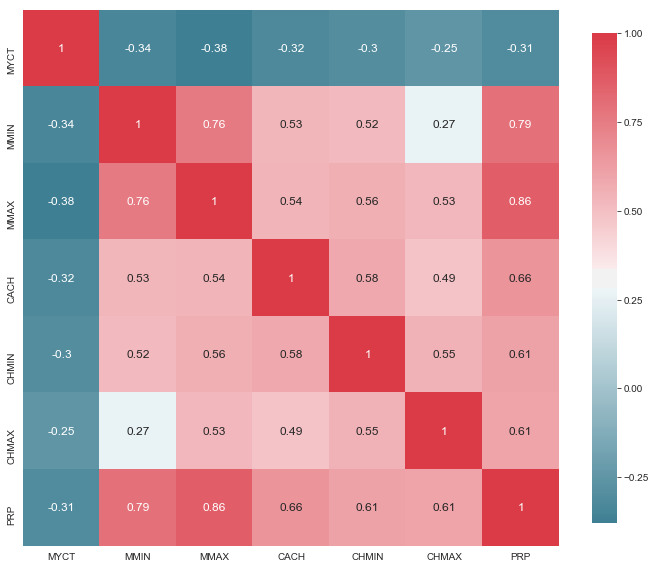

In [68]:
#corrplot for Cach_zero


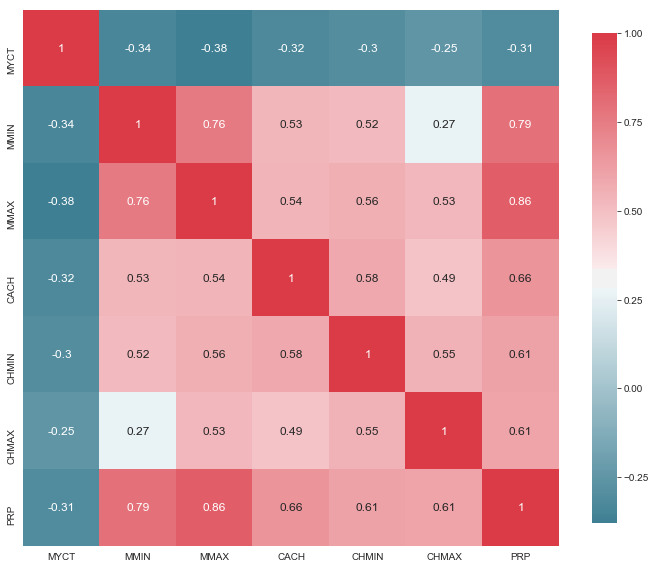

In [69]:
#Corr plot for data to compare with the above
plot_correlation_map(data.loc[data['CACH']!= 0])

From the above Corr plot we can see the Dependent variable has 61% to 86% of correlation with the independent variables.
<br>
Note: 'correlation doesn't imply causation'
<br>
Refer: https://towardsdatascience.com/why-correlation-does-not-imply-causation-5b99790df07e

Now coming back to log transformation, adding constant '1' to the columns where it comtains values equal to '0'

In [84]:
data['CACH'] = data['CACH']+1
data['CHMIN'] = data['CHMIN']+1
data['CHMAX'] = data['CHMAX'] +1

In [85]:
(data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']]).apply(lambda column: (column<= 0).sum())

MYCT     0
MMIN     0
MMAX     0
CACH     0
CHMIN    0
CHMAX    0
PRP      0
dtype: int64

In [86]:
data_log = np.log(data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']])

In [101]:
print('Before Log Transformed')
(data.iloc[:,2:].head(5))




Before Log Transformed


,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,125,256,6000,257,17,129,198
1,29,8000,32000,33,9,33,269
2,29,8000,32000,33,9,33,220
3,29,8000,32000,33,9,33,172
4,29,8000,16000,33,9,17,132


In [98]:
print('After Log Transformed')

(data_log.head())

After Log Transformed


,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,4.828314,5.545177,8.699515,5.549076,2.833213,4.859812,5.288267
1,3.367296,8.987197,10.373491,3.496508,2.197225,3.496508,5.594711
2,3.367296,8.987197,10.373491,3.496508,2.197225,3.496508,5.393628
3,3.367296,8.987197,10.373491,3.496508,2.197225,3.496508,5.147494
4,3.367296,8.987197,9.680344,3.496508,2.197225,2.833213,4.882802


In [102]:
data_log[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']].skew() #Checking skewness for the data_log

MYCT     0.397838
MMIN     0.036612
MMAX    -0.617669
CACH     0.042585
CHMIN    0.802618
CHMAX    0.136018
PRP      0.521715
dtype: float64

In [103]:
data_transformed = pd.concat([data[['VENDOR','MODEL_NAME']],data_log], axis=1, ignore_index=False) #Combaining data_log dataframe & 'VENDOR','MODEL_NAME' columns from data
data_transformed.head()

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,4.828314,5.545177,8.699515,5.549076,2.833213,4.859812,5.288267
1,amdahl,470v/7,3.367296,8.987197,10.373491,3.496508,2.197225,3.496508,5.594711
2,amdahl,470v/7a,3.367296,8.987197,10.373491,3.496508,2.197225,3.496508,5.393628
3,amdahl,470v/7b,3.367296,8.987197,10.373491,3.496508,2.197225,3.496508,5.147494
4,amdahl,470v/7c,3.367296,8.987197,9.680344,3.496508,2.197225,2.833213,4.882802


In [106]:
print("mean : ", np.mean(data_transformed[data_transformed.columns[2:]]))
print("var  : ", np.var(data_transformed[data_transformed.columns[2:]]))
print("skew : ",(data_transformed[data_transformed.columns[2:]]).skew())
print("kurt : ",(data_transformed[data_transformed.columns[2:]]).kurtosis())

mean :  MYCT     4.746955
MMIN     7.360234
MMAX     8.922222
CACH     2.075453
CHMIN    1.355234
CHMAX    2.407778
PRP      4.037242
dtype: float64
var  :  MYCT     1.072055
MMIN     1.212674
MMAX     1.060236
CACH     2.900684
CHMIN    0.645803
CHMAX    1.068150
PRP      1.093810
dtype: float64
skew :  MYCT     0.397838
MMIN     0.036612
MMAX    -0.617669
CACH     0.042585
CHMIN    0.802618
CHMAX    0.136018
PRP      0.521715
dtype: float64
kurt :  MYCT    -0.542415
MMIN    -0.090215
MMAX     1.487443
CACH    -1.336633
CHMIN   -0.004955
CHMAX   -0.053167
PRP     -0.034942
dtype: float64


In [172]:
data_transformed.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,4.746955,7.360234,8.922222,2.075453,1.355234,2.407778,4.037242
std,1.037887,1.103859,1.032150,1.707229,0.805548,1.035995,1.048365
min,2.833213,4.158883,4.158883,0.000000,0.000000,0.000000,1.791759
25%,3.912023,6.643790,8.294050,0.000000,0.693147,1.791759,3.295837
50%,4.700480,7.600902,8.987197,2.197225,1.098612,2.197225,3.912023
75%,5.416100,8.294050,9.680344,3.496508,1.945910,3.218876,4.727388
max,7.313220,10.373491,11.066638,5.549076,3.970292,5.176150,7.047517


In [173]:
#From data_transformed creating df & y dataframes for Independent & Dependent variables
df = data_transformed[data_transformed.columns[0:8]]
y = data_transformed[data_transformed.columns[-1:]]

0.8947368421052632


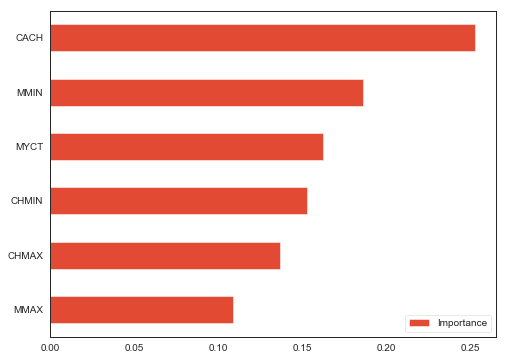

In [174]:
plot_variable_importance(data_transformed[data_transformed.columns[2:-1]].astype('int'), y.astype('int'))

In [175]:
#Onehot coding for VENDOR & MODEL

df_V_M = df.iloc[:,0:2]

In [176]:
df_V_M.head()
df_V_M = pd.get_dummies(df_V_M) 
df = pd.concat( [df_V_M,df ] , axis=1 ).sort_index()
df = df.drop(columns=['VENDOR', 'MODEL_NAME'])

#list(df)

In [118]:
# One-hot encode the data using pandas get_dummies
#features = pd.get_dummies(df)

In [119]:
# Labels are the values we want to predict
#labels = np.array(y)

In [120]:
# Remove the labels from the features
# axis 1 refers to the columns
#features= features
# Saving feature names for later use
#-feature_list = list(features)
# Convert to numpy array
#features = np.array(features)


In [177]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df,y, test_size = 0.15, random_state = 42)

In [178]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (177, 245)
Training Labels Shape: (177, 1)
Testing Features Shape: (32, 245)
Testing Labels Shape: (32, 1)


#Using Randomforest Algorithm

In [179]:
#train_features[1:10,0:10]

In [233]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

Since the rf output is 'numpy.ndarray' we need to convert test_lables to np array

In [234]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
print(type(predictions), type(test_labels))
# Calculate the absolute errors
errors = ((predictions) - np.array(test_labels)) #Here converting the test_lables to 'np.array' to calculate the 'errors'
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '.')

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Mean Absolute Error: 0.05 .


In [193]:
# Use the forest's predict method on the test data
#predictions = rf.predict(test_features)
# Calculate the absolute errors
#errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [235]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * ((errors / np.array(test_labels)))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.08 %.


#Trying linear regression model

#lm method

In [200]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(train_features, train_labels)
predictions = lm.predict(test_features)


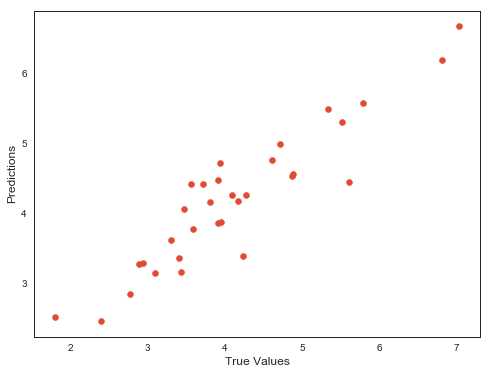

Score: 0.8439903521778682


In [201]:
## The line / model
plt.scatter(test_labels, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

print ('Score:', model.score(test_features, test_labels))


Here we can see that linear method got us 84% accuracy not bad but comparing to RF its poor.

Cross-validated scores: [0.63588496 0.6950036  0.85087314 0.42816227 0.82099471 0.83804225]


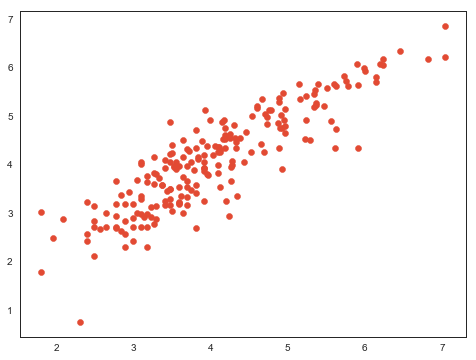

Cross-Predicted Accuracy: 0.7728058784588024


In [50]:
#Cross Validation
#from sklearn.model_selection import KFold # import KFold

# Necessary imports:
#from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn import metrics

# Perform 6-fold cross validation
#scores = cross_val_score(model, full_data, y, cv=5)
#print ('Cross-validated scores:', scores)

# Make cross validated predictions
#predictions = cross_val_predict(model, full_data, y, cv=6)
#plt.scatter(y, predictions)
#plt.show()


#accuracy = metrics.r2_score(y, predictions)
#print ('Cross-Predicted Accuracy:', accuracy)



#GradientBoosting Regressor

In [205]:
from sklearn.ensemble import GradientBoostingRegressor
model= GradientBoostingRegressor()
model.fit(train_features, train_labels)
model.score(test_features,test_labels)

0.8641048773828798

In [209]:
print ('Score:', model.score(test_features, test_labels))

Score: 0.8641048773828798


In [207]:
predictions = model.predict(test_features)

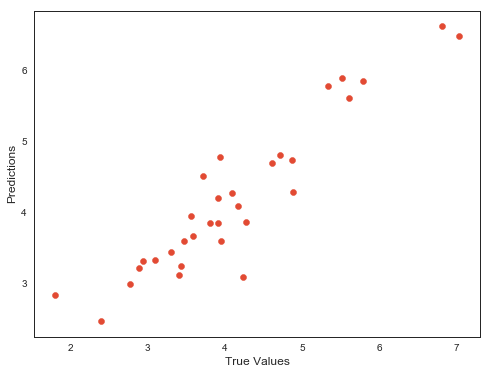

In [208]:
## The line / model
plt.scatter(test_labels, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


#AdaBoostRegressor

In [228]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor()
model.fit(train_features , train_labels)
model.score(test_features,test_labels)

0.8415675255043893

In [229]:
predictions = model.predict(test_features)

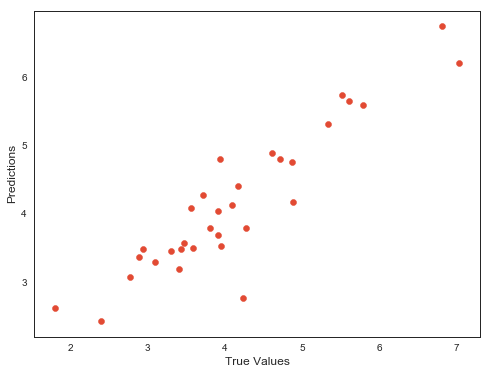

In [230]:
## The line / model
plt.scatter(test_labels, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [231]:
print ('Score:', model.score(test_features, test_labels))

Score: 0.8415675255043893


#BaggingRegressor

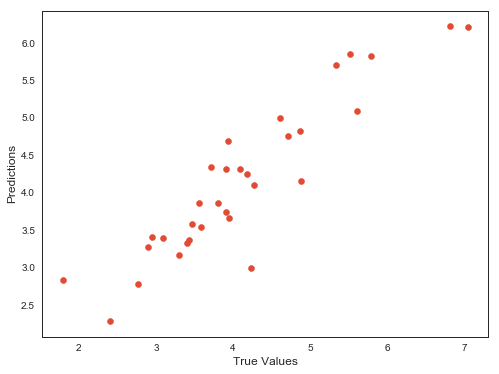

Score: 0.8425421640487728


In [232]:
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
model = BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))
model.fit(train_features , train_labels)
model.score(test_features,test_labels)
predictions = model.predict(test_features)
## The line / model
## The line / model
plt.scatter(test_labels, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
print ('Score:', model.score(test_features, test_labels))

As we can see here,

* Random forest Regressor gives **90.08 %** of Accuracy
<br>
* Linear regression gives **84.39%** of Accuracy
<br>
* Gradient Boosting Regressor gives **86.41%** of Accuracy
<br>
* AdaBoost Regressor gives **84.15%** of Accuracy
<br>
* Bagging Regressor gives **84.25%** of Accuracy

Going forward we can create more features, do some data transformation, or even convert the regression into a classification if predicting the class of PRP is useful.